# check oof df

In [1]:
import os
import gc
import yaml
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/kaggle/src/dss_utils")
sys.path.append("/kaggle/src/exp")
sys.path.append("/kaggle/src/model")
sys.path.append("/kaggle/src/data")
from dss_metrics import score
from training_loop import get_valid_values_dict, concat_valid_input_info, get_oof_df, get_key_df
from dss_model import get_model
from dss_dataloader import get_loader


In [2]:
output_dir = "/kaggle/working"
exp_name = "exp017_inputtargettd_flip_epoch10"

folds = [0, 1, 2, 3, 4]
oof_df = pd.DataFrame()
for i in folds:
    print("fold", i)
    # df = pd.read_parquet(os.path.join(output_dir, "_oof", exp_name, f"raw_oof_df_fold{i}.parquet"))
    df = pd.read_parquet(os.path.join(output_dir, "_oof", exp_name, f"oof_df_fold{i}.parquet"))
    oof_df = pd.concat([oof_df, df], axis=0)


fold 0
fold 1
fold 2
fold 3
fold 4


In [3]:
oof_df = oof_df.sort_values(["series_id", "step"])


In [4]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn


# 1step 0.5secで30minなら60*30=1800step
def postprocess_downsample_fn(df, N=3, maxpool_kernel_size=3, maxpool_stride=1):
    df = df.copy()
    df = df[df["second"]==0].reset_index(drop=True)
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    not_predicted_mask = (df["class_pred"] != -1).astype(int)
    df["event_pred"] = df["event_pred"] * not_predicted_mask

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df

def postprocess_downsample_notmaxpool(df, N=11):
    df = df.copy()
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df

def make_submission_df(df, threshold=0.1):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df


In [5]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["step"].notnull()].copy()
train_event_df = train_event_df.reset_index(drop=True)


In [6]:
score_df = pd.read_csv(os.path.join(output_dir, "_oof", exp_name, "score_df.csv"))


In [7]:
orig_df = pd.read_parquet("/kaggle/input/targetdownsample_train_series_fold.parquet")


In [11]:
def display_series_scoredf(orig_df, oof_df, train_event_df, series_id):
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    key_unique = input_df["series_date_key"].unique()
    print(len(input_df)/17280)
    score_list = []
    key_list = []
    for key in key_unique:
        input_key_df = input_df[input_df["series_date_key"] == key]
        start_step = input_key_df["step"].min()
        end_step = input_key_df["step"].max()
        pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
        scoring_event_df = train_event_df[train_event_df["series_id"] == series_id].copy()
        scoring_event_df = scoring_event_df[(scoring_event_df["step"] >= start_step) & (scoring_event_df["step"] <= end_step)]
        sub_df = make_submission_df(pred_key_df, threshold=0.01)
        if len(sub_df["event"].unique()) < 2 or len(scoring_event_df["event"].unique()) < 2:
            score_list.append(0)
            key_list.append(key)
        else:
            score_list.append(score(scoring_event_df, sub_df))
            key_list.append(key)

    df = pd.DataFrame({"key": key_list, "score": score_list}).sort_values("score").reset_index(drop=True)
    display(pd.DataFrame({"key": key_list, "score": score_list}).sort_values("score", ascending=False).reset_index(drop=True))
    key_list = df["key"].values.tolist()
    return key_list


In [13]:
def show_input_target_in_key(orig_df, oof_df, key, series_id):
    input_df = orig_df[orig_df["series_id"] == series_id]
    pred_df = oof_df[oof_df["series_id"] == series_id]
    input_key_df = input_df[input_df["series_date_key"] == key]
    print(input_key_df["series_id"].unique())
    start_step = input_key_df["step"].min()
    end_step = input_key_df["step"].max()
    pred_key_df = pred_df[(pred_df["step"] >= start_step) & (pred_df["step"] <= end_step)]
    scoring_event_df = train_event_df[train_event_df["series_id"] == series_id].copy()
    scoring_event_df = scoring_event_df[(scoring_event_df["step"] >= start_step) & (scoring_event_df["step"] <= end_step)]
    sub_df = make_submission_df(pred_key_df, threshold=0.01)
    print(scoring_event_df["step"].values)

    plt.figure(figsize=(20, 5))
    plt.subplot(5, 1, 1)
    plt.plot(input_key_df["anglez"])
    plt.subplot(5, 1, 2)
    plt.plot(input_key_df["enmo"])
    plt.subplot(5, 1, 3)
    plt.plot(input_key_df["step"], input_key_df["event"])
    # plt.plot(input_key_df["step"]-12*60*6, input_key_df["event"])
    plt.subplot(5, 1, 4)
    plt.plot(pred_key_df["class_pred"])
    plt.subplot(5, 1, 5)
    plt.plot(pred_key_df["step"], pred_key_df["event_pred"])
    plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_onset"].values, ":")
    plt.plot(input_key_df[input_key_df["second"]==0]["step"], input_key_df[input_key_df["second"]==0]["event_wakeup"].values, ":")
    plt.tight_layout()
    plt.show()


In [17]:
score_df = score_df.sort_values("score")
score_df.head(10)


,series_id,score,detected_event_num
100,60d31b0bec3b,0.054950,390
258,f56824b503a0,0.082263,137
81,4feda0596965,0.116124,187
241,e4500e7e19e1,0.127249,24
132,854206f602d0,0.306222,52
181,b7fc34995d0f,0.365635,24
194,c535634d7dcd,0.394813,137
118,7476c0bd18d2,0.407306,44
225,db5e0ee1c0ab,0.435557,551
101,60e51cad2ffb,0.448611,49


In [19]:
series_id = "7476c0bd18d2"
key_list = display_series_scoredf(orig_df, oof_df, train_event_df, series_id=series_id)


2.0


,key,score
0,3338,0.95
1,3339,0.00


['7476c0bd18d2']
[73836. 75348.]


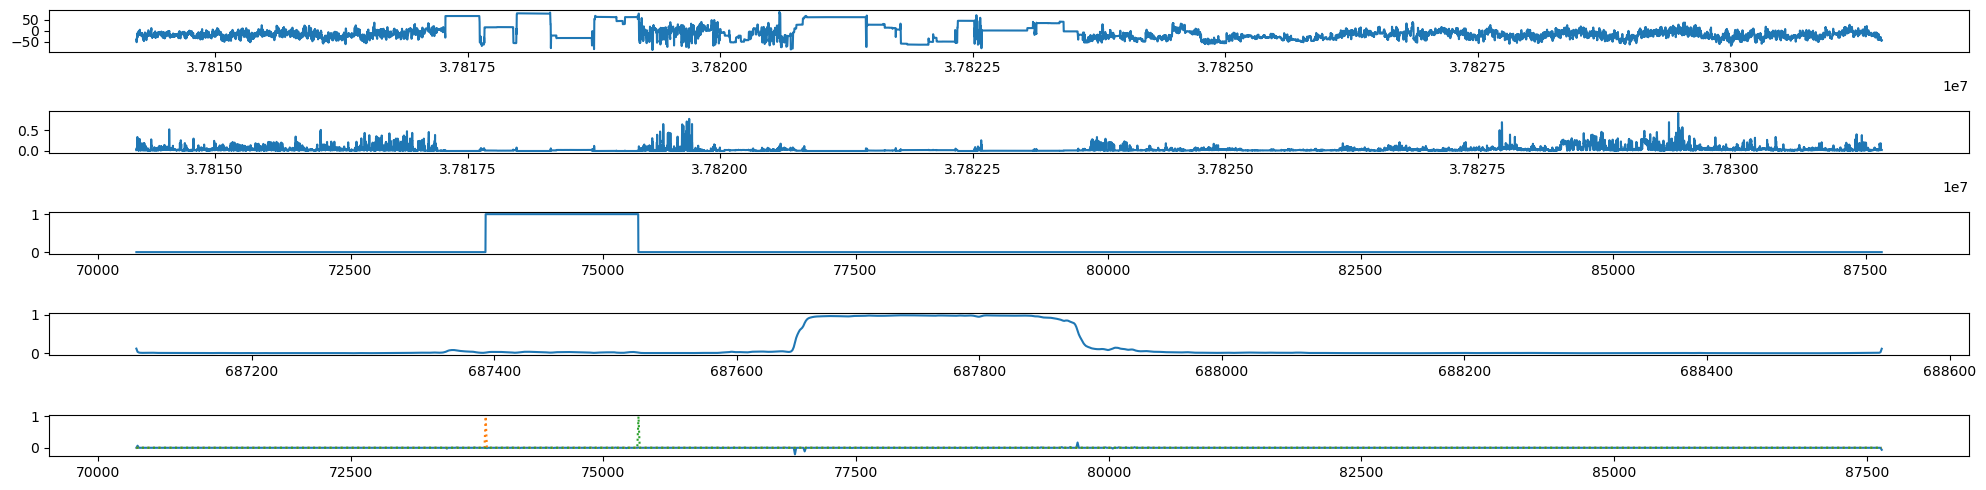

In [21]:
show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key_list[0])


In [22]:
series_id = "c535634d7dcd"
key_list = display_series_scoredf(orig_df, oof_df, train_event_df, series_id=series_id)


7.552083333333333


,key,score
0,5495,0.612500
1,5492,0.603409
2,5490,0.600000
3,5496,0.525000
4,5497,0.450000
5,5493,0.350000
6,5491,0.250000
7,5494,0.000000


5495
['c535634d7dcd']
[ 93672. 100428.]


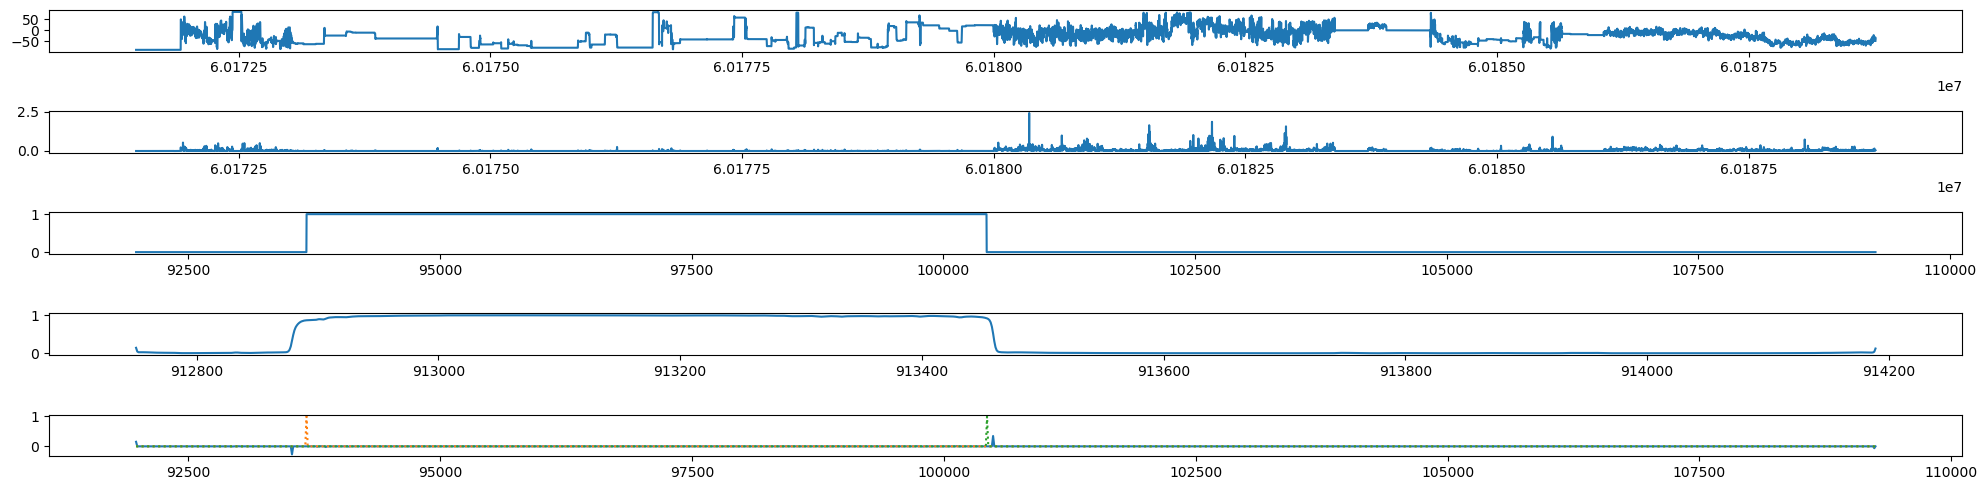

5492
['c535634d7dcd']
[41736. 49452. 57048.]


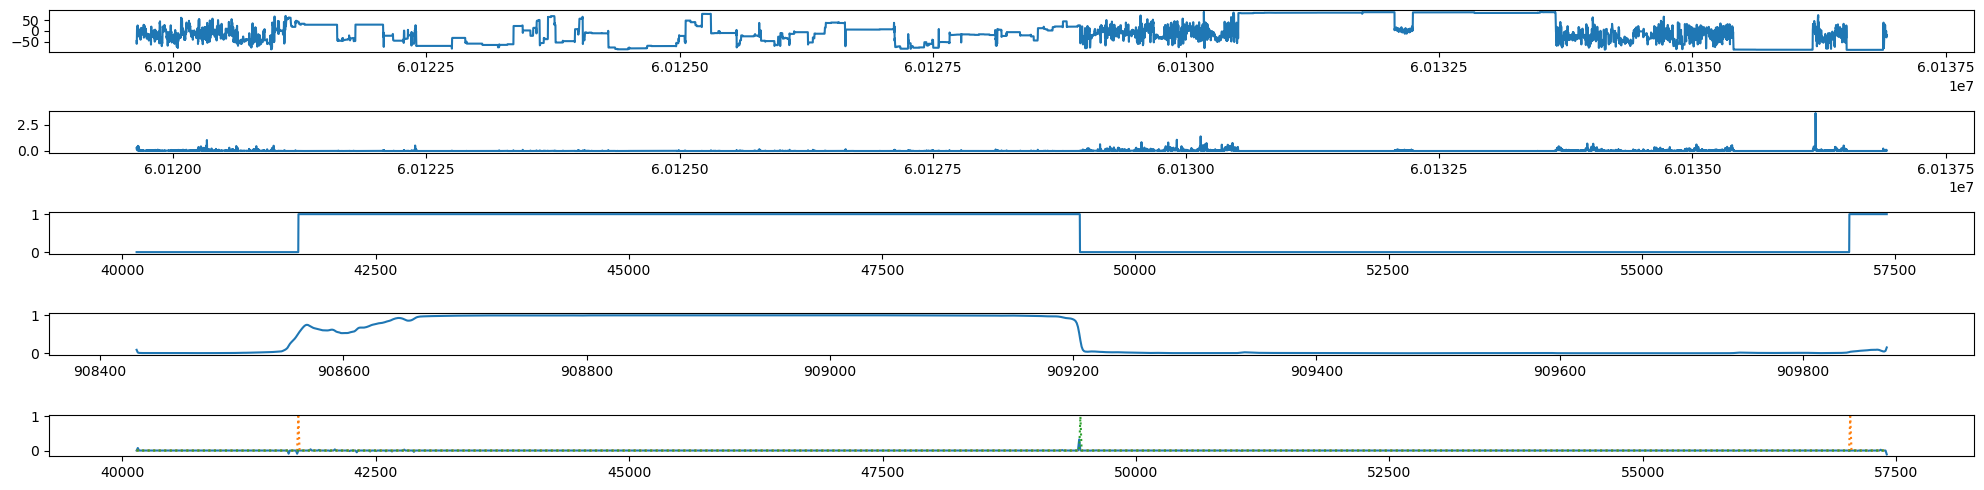

5490
['c535634d7dcd']
[ 7020. 14808.]


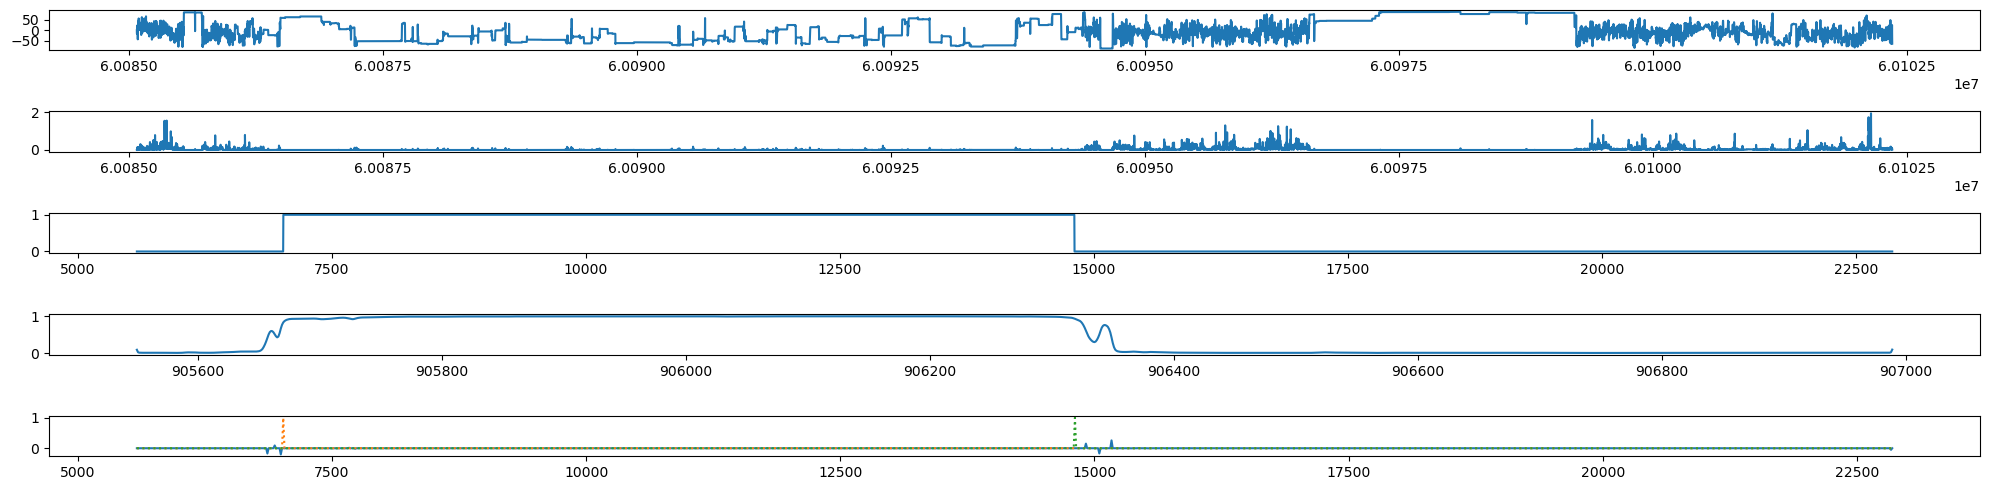

5496
['c535634d7dcd']
[111600. 117492.]


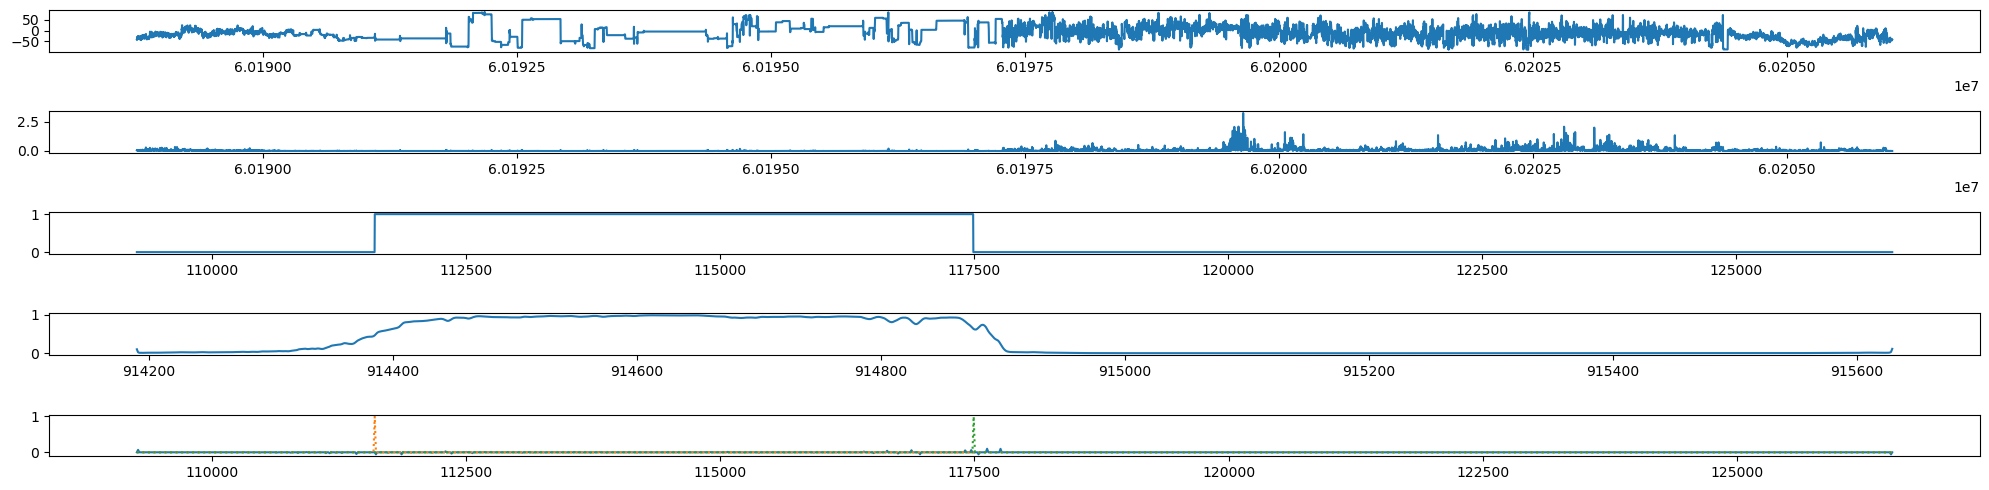

5497
['c535634d7dcd']
[127956. 133416.]


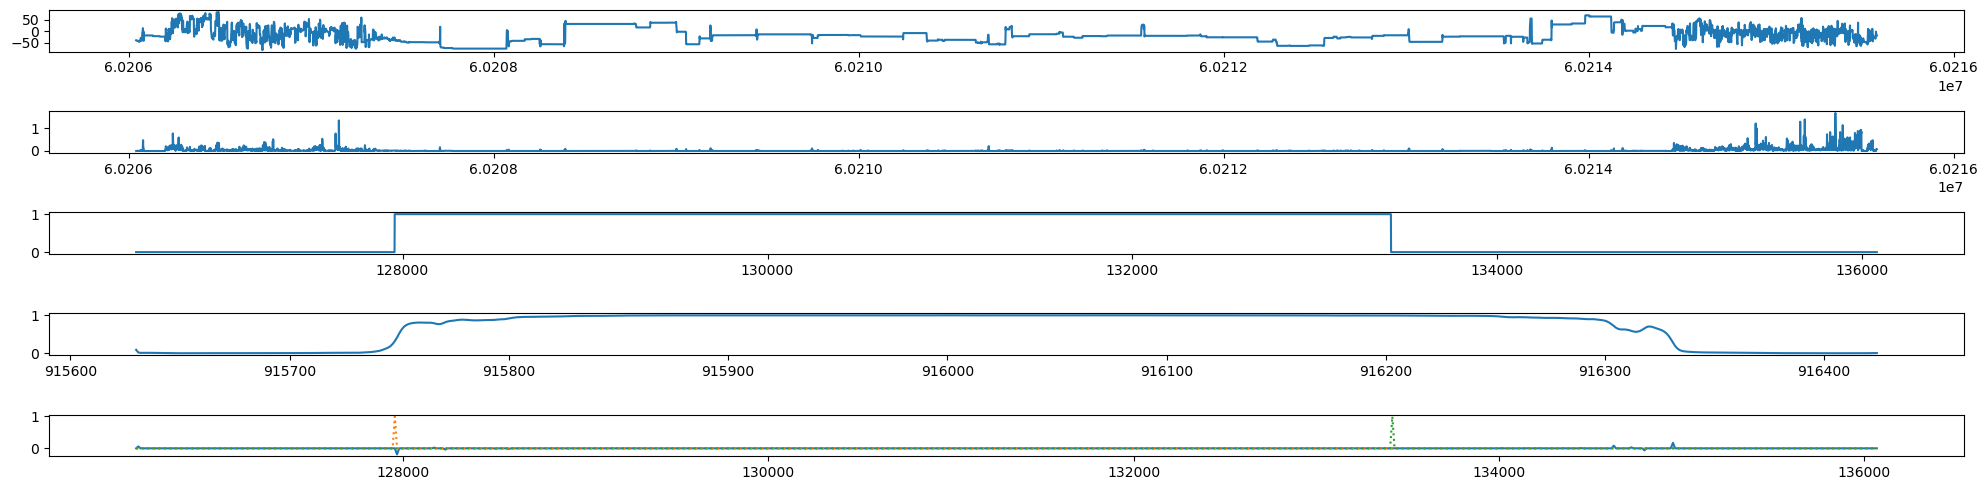

In [27]:
for idx, key in enumerate(key_list[::-1]):
    print(key)
    show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)
    if idx > 3:
        break


21.0


,key,score
0,6380,0.950000
1,6394,0.950000
2,6395,0.900000
3,6385,0.850000
4,6383,0.775000
5,6396,0.750000
6,6392,0.637500
7,6376,0.625000
8,6384,0.608333
9,6388,0.568750


6389
['db5e0ee1c0ab']
[246324. 250044.]


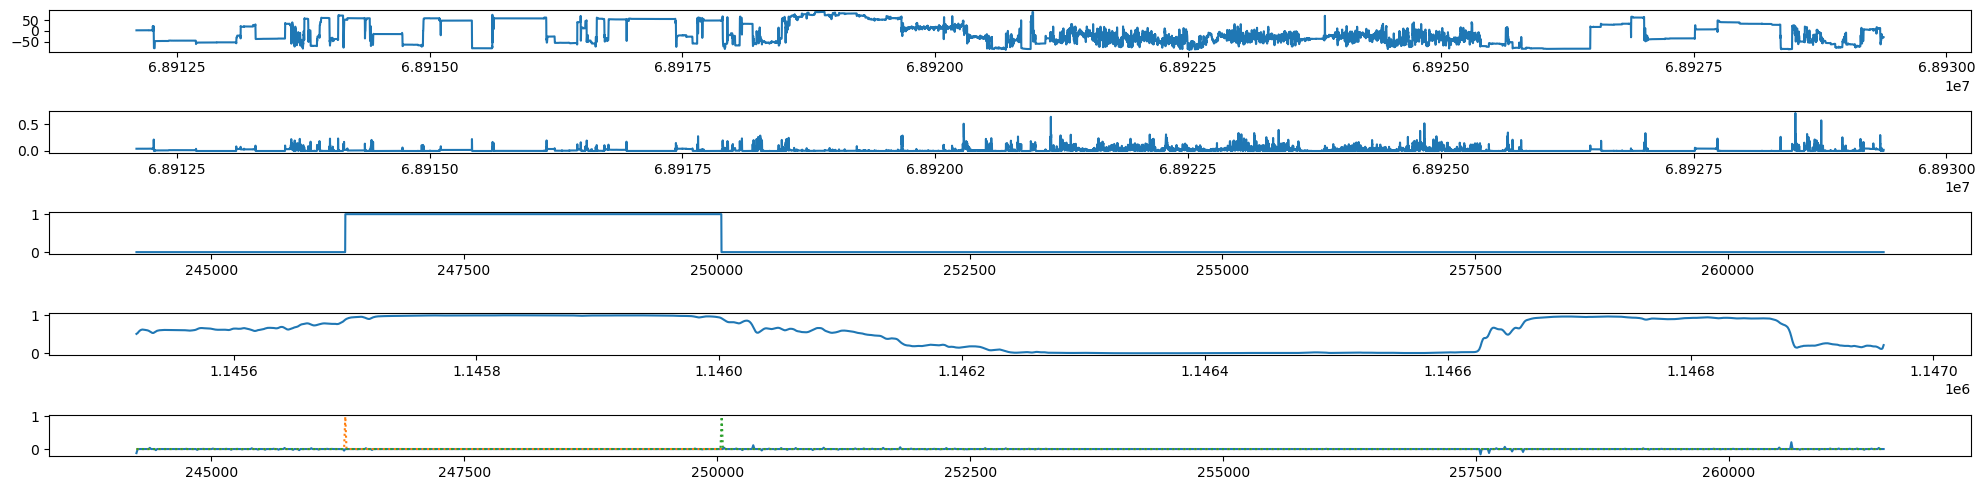

6391
['db5e0ee1c0ab']
[280212. 285840.]


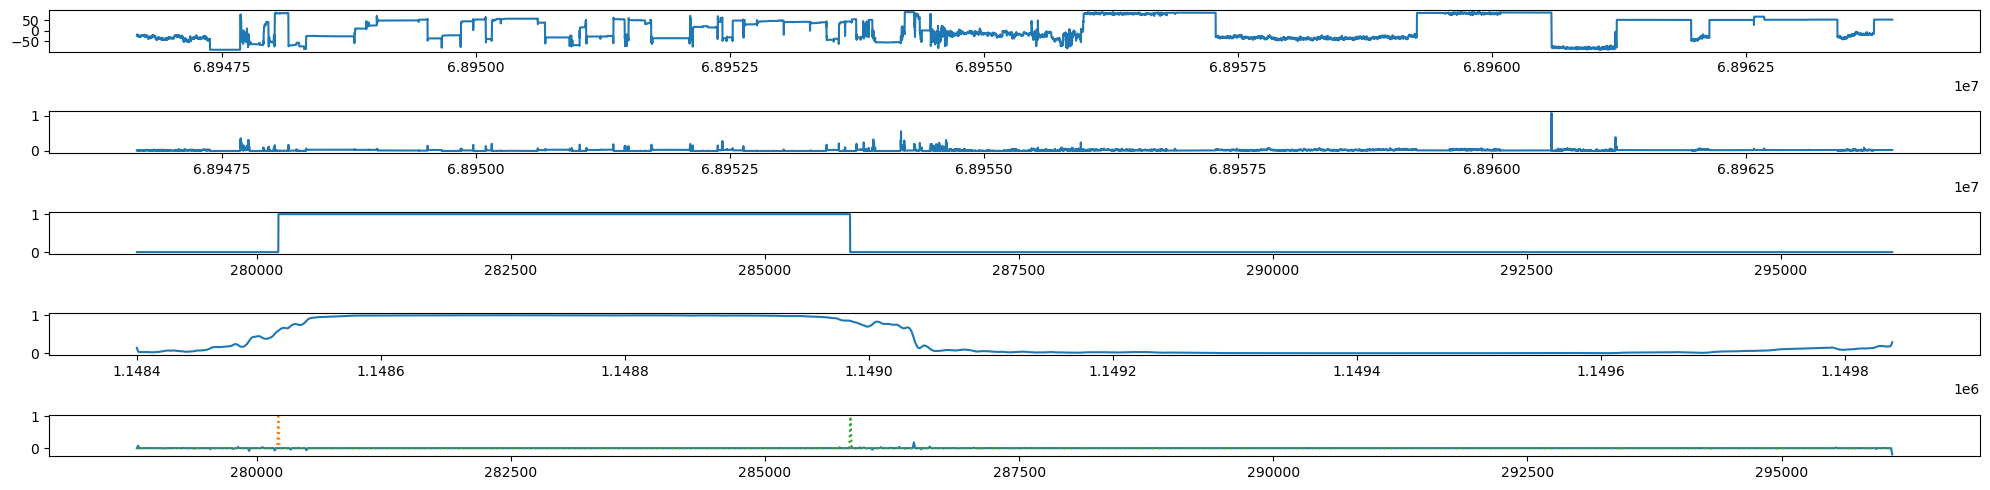

6397
['db5e0ee1c0ab']
[383892. 390504.]


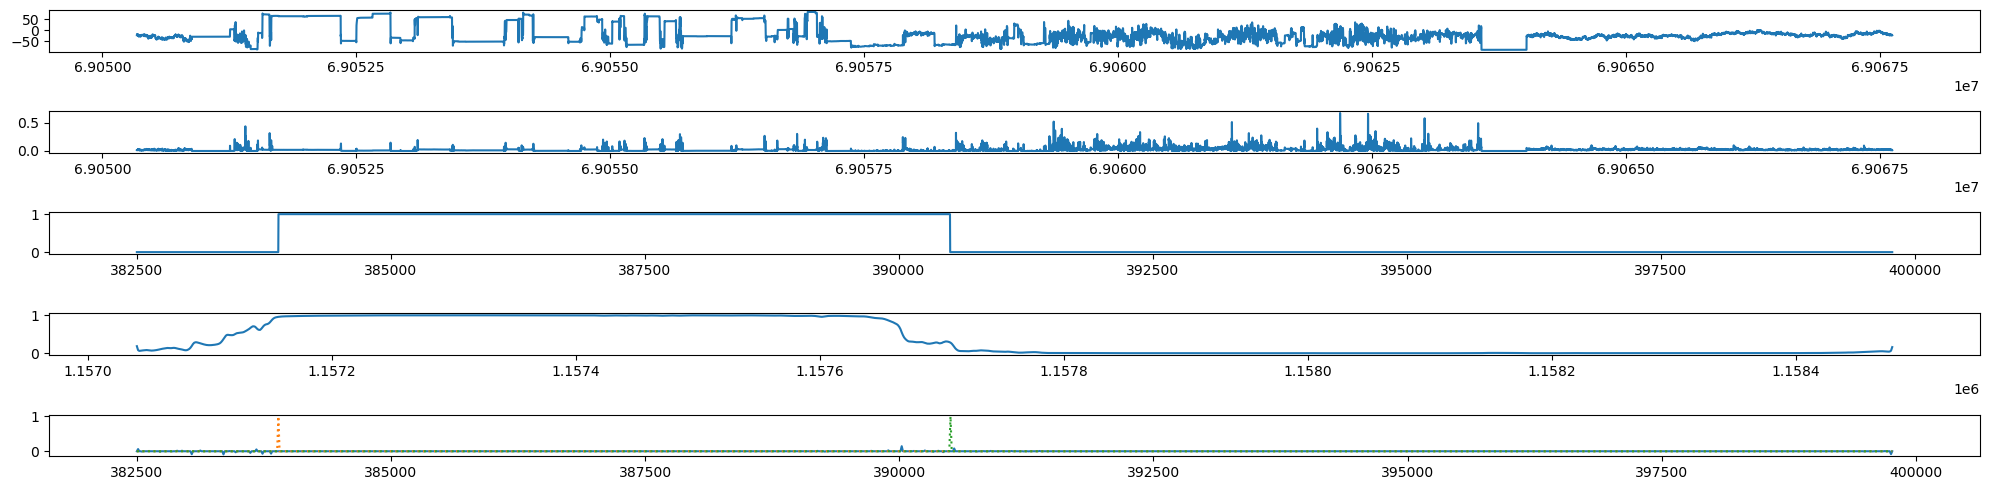

6399
['db5e0ee1c0ab']
[418020. 424740.]


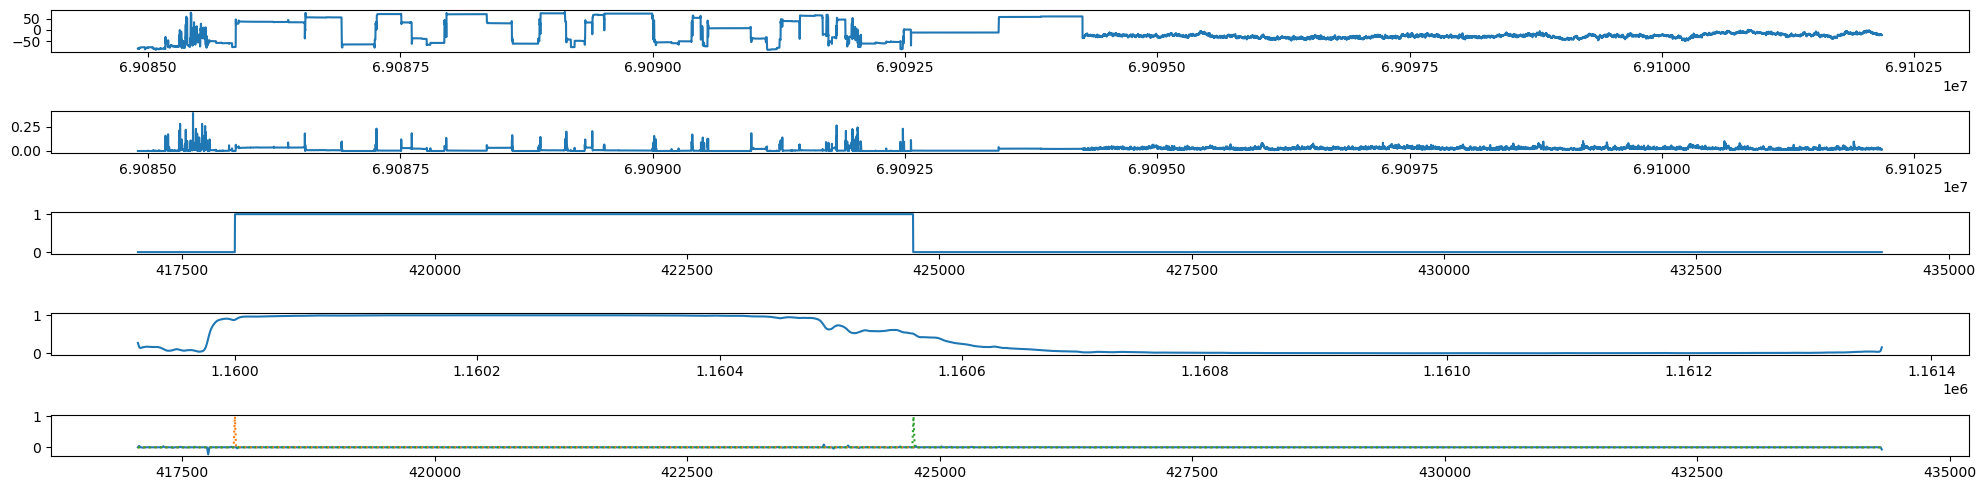

6390
['db5e0ee1c0ab']
[264960. 269640.]


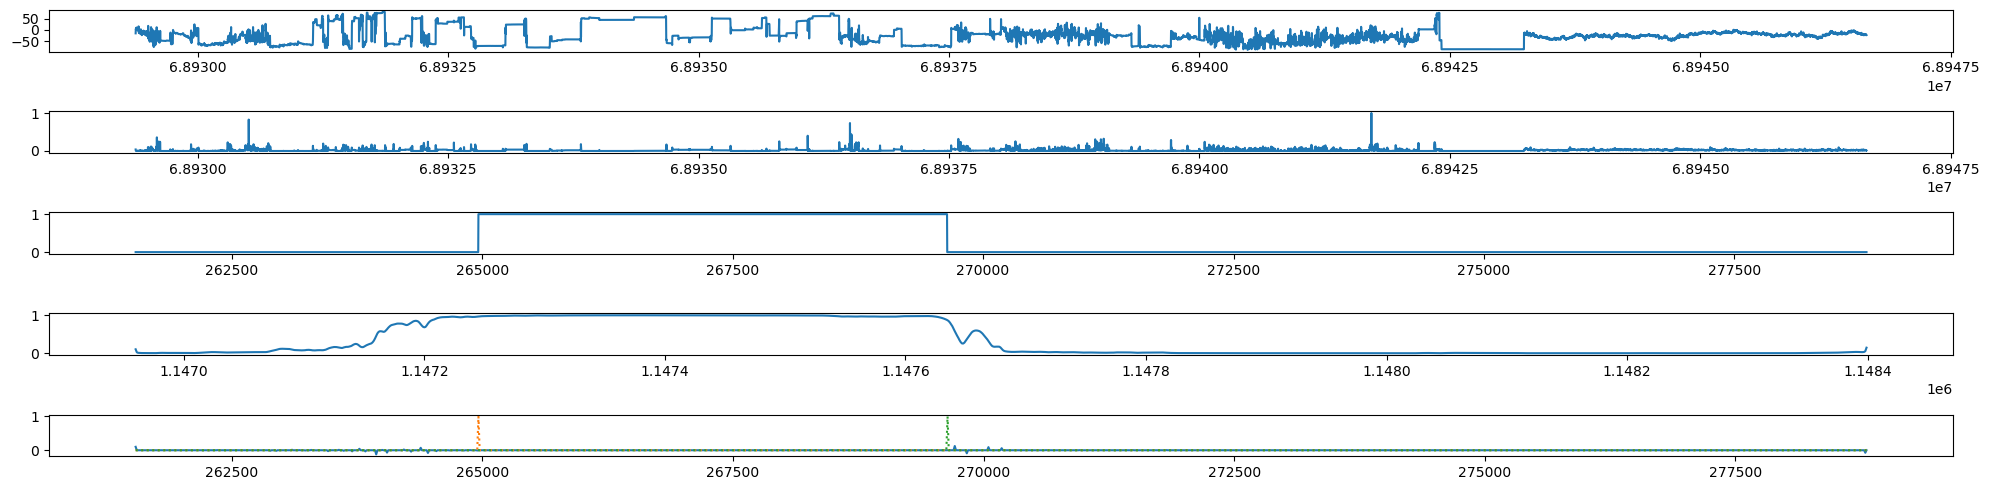

In [29]:
series_id = "db5e0ee1c0ab"
key_list = display_series_scoredf(orig_df, oof_df, train_event_df, series_id=series_id)
for idx, key in enumerate(key_list):
    print(key)
    show_input_target_in_key(orig_df, oof_df, series_id=series_id, key=key)
    if idx > 3:
        break
